In [17]:
# 定义目标对象
target = 'Close'
import os
os.makedirs('tmp', exist_ok=True)

### 1 获取数据 (需要代理)

In [18]:
import yfinance as yf
from datetime import datetime

# 示例调用
stock = 'TSN'  # 股票名称
start_date = datetime(2010, 1, 1)  # 开始日期
end_date = datetime(2024, 6, 14)  # 结束日期


def fetch_stock_data(stock, start_date, end_date):
    # 将日期转换为字符串格式
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    # 使用yfinance库获取股票数据
    stock_data = yf.download(stock, start=start_date_str, end=end_date_str)

    # # 获取额外的财务数据
    # ticker = yf.Ticker(stock)
    # info = ticker.info

    # # 添加换手率（假设日换手率可以用每日交易量 / 总流通股数来近似）
    # stock_data['Turnover Rate'] = stock_data['Volume'] / info.get('floatShares', 1)
    # stock_data.drop(columns=['Volume'], inplace=True)

    # # 重命名列
    stock_data.reset_index(inplace=True)
    stock_data.rename(columns={'Date': 'Date', 'Open': 'Open', 'High': 'High', 'Low': 'Low', 'Close': 'Close'},
                      inplace=True)

    return stock_data, start_date_str, end_date_str


def save_to_csv(dataframe, filename):
    dataframe.to_csv(filename, index=False)
    print(f"Data saved to {filename}")


try:
    stock_data, start_date_str, end_date_str = fetch_stock_data(stock, start_date, end_date)
    filename = f'./tmp/{stock}_{start_date_str}_{end_date_str}.csv'
    save_to_csv(stock_data, filename)
except Exception as e:
    print(e)


[*********************100%%**********************]  1 of 1 completed

Data saved to ./tmp/TSN_2010-01-01_2024-06-14.csv


In [21]:
### 2、没有确实值，去除异常值

Number of anomalies detected and removed: 87
Number of data points after removal: 3549


C:\Users\admin\AppData\Local\Temp\ipykernel_22944\2916855270.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  anomalies = anomalies.applymap(lambda x: 1 if x == -1 else 0)


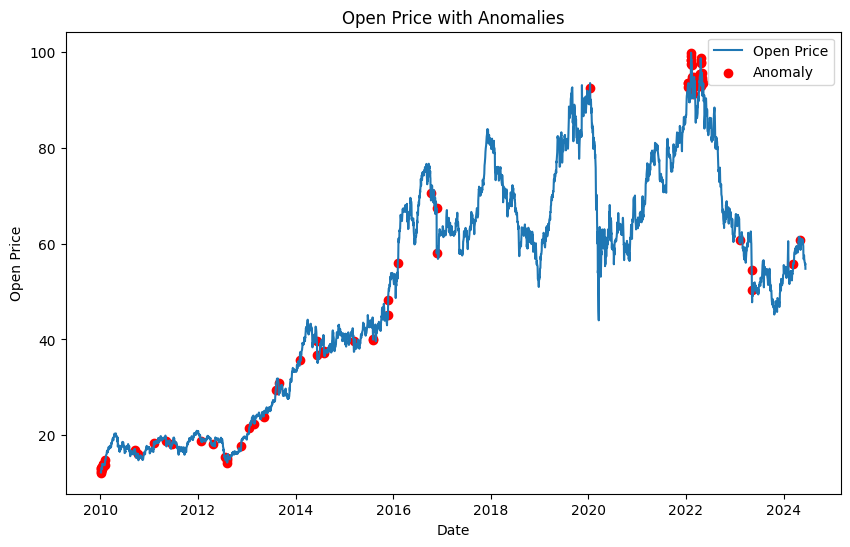

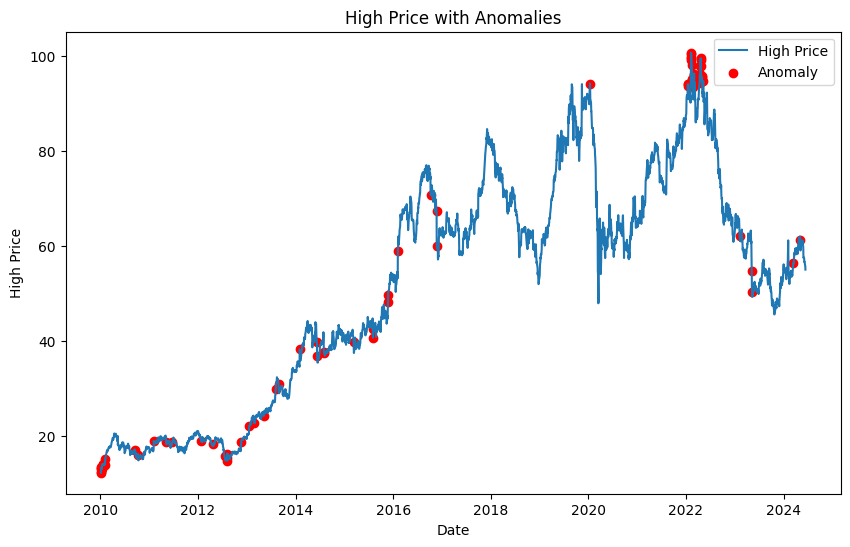

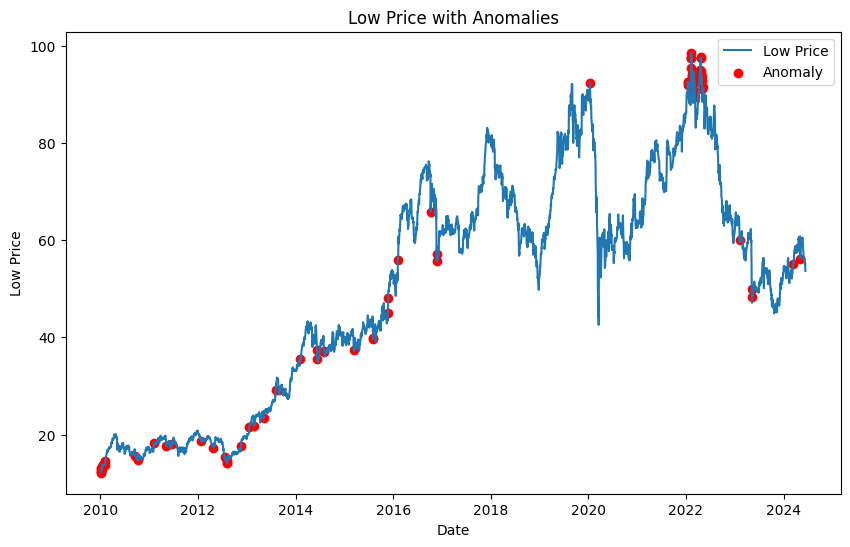

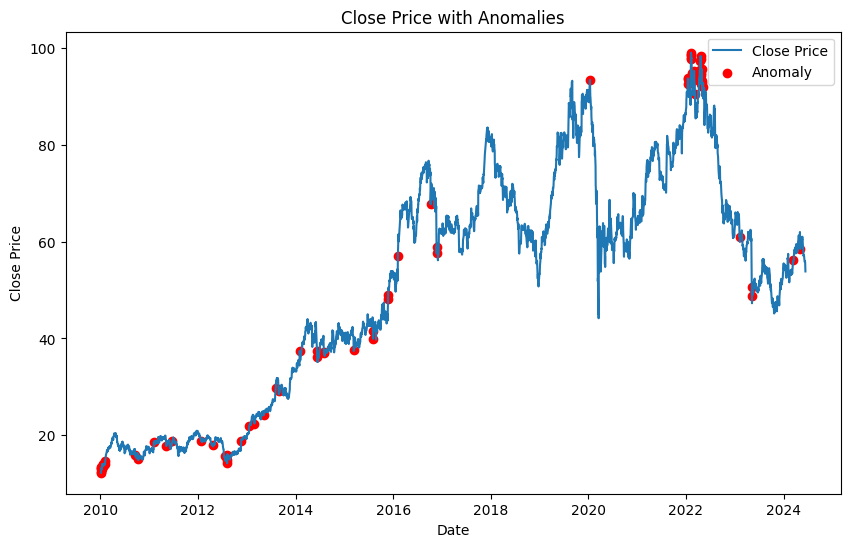

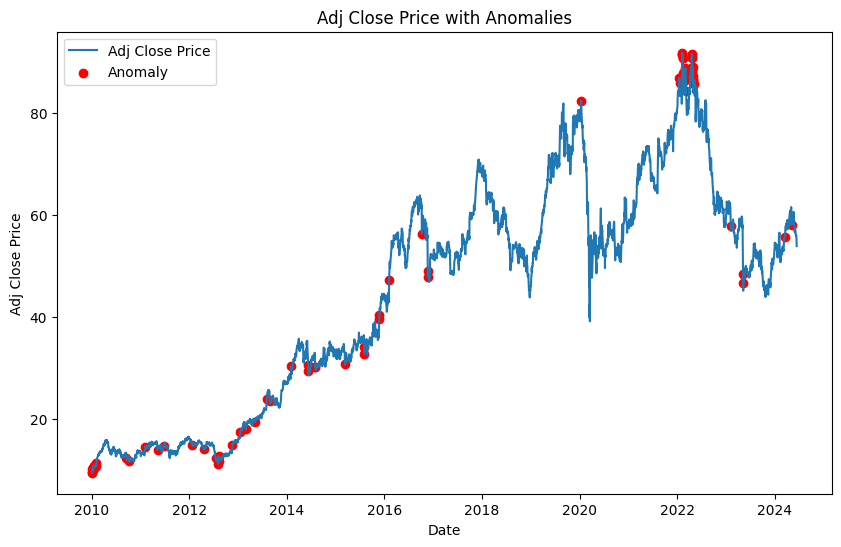

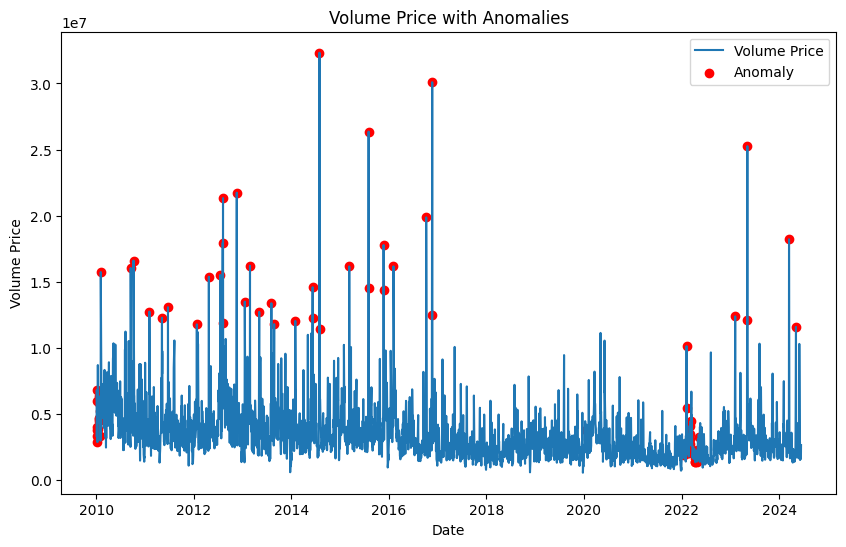

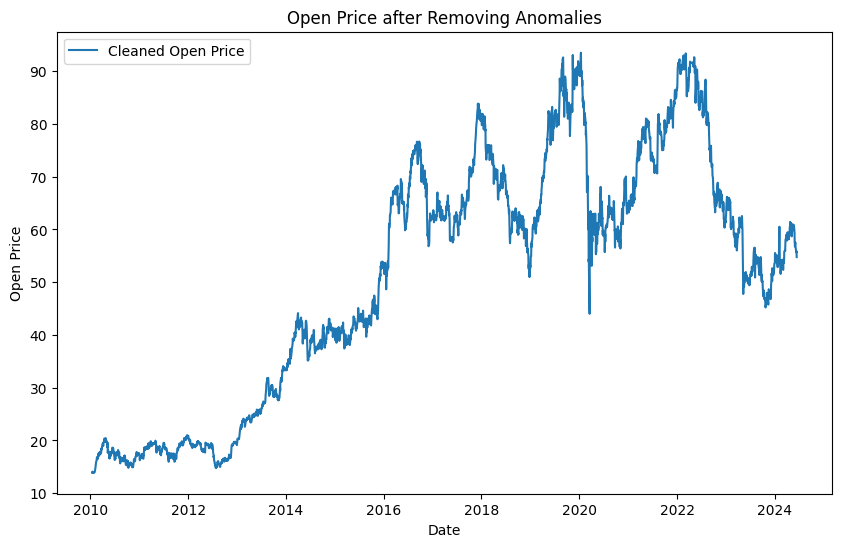

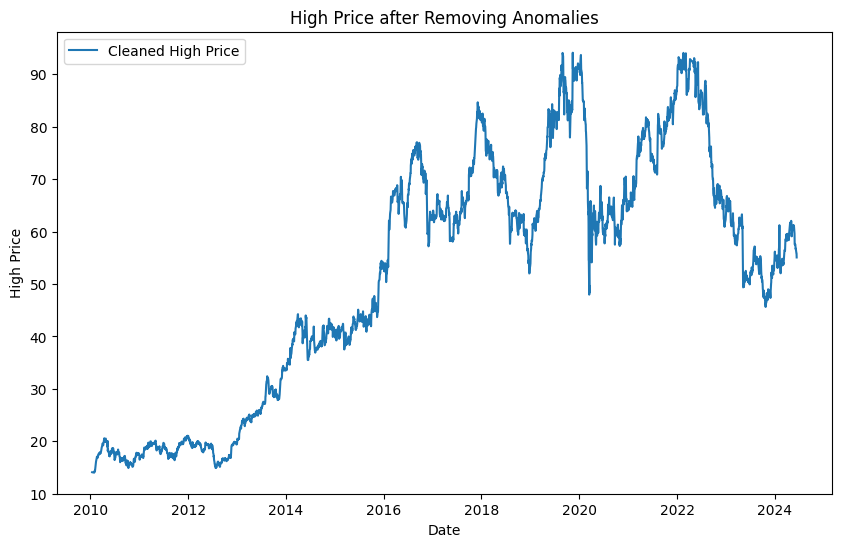

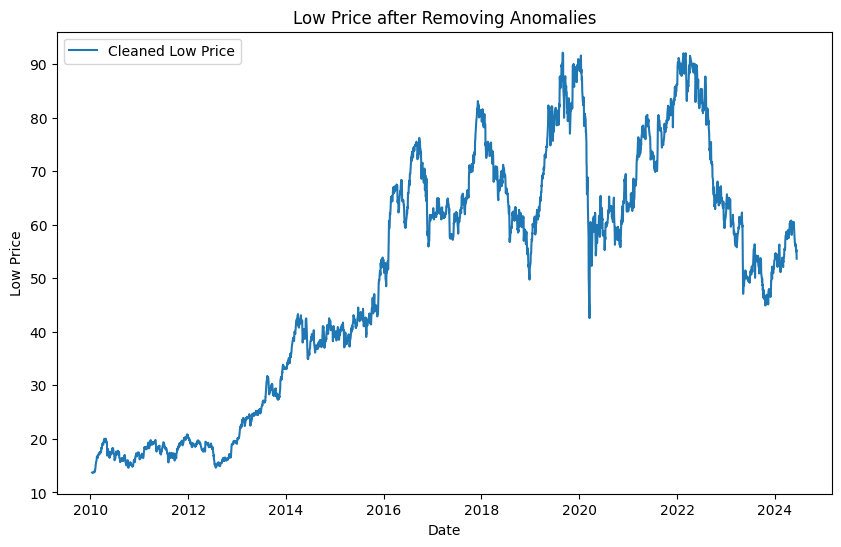

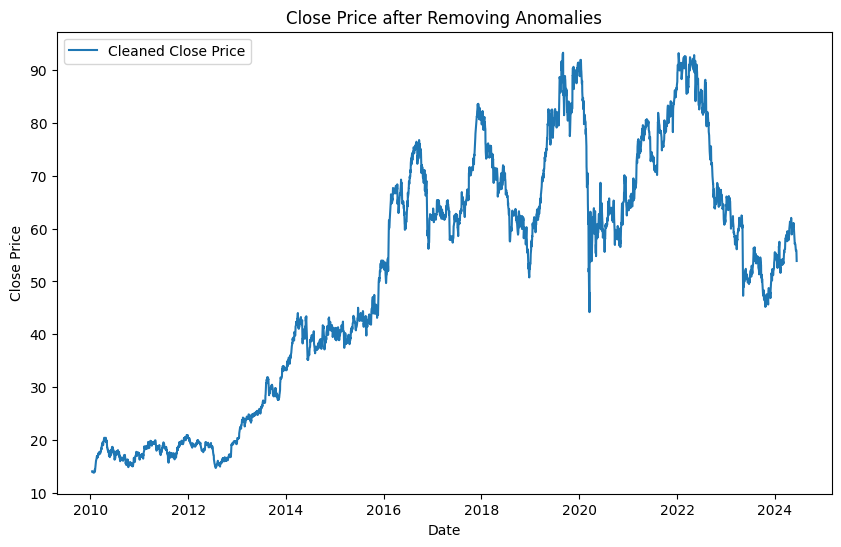

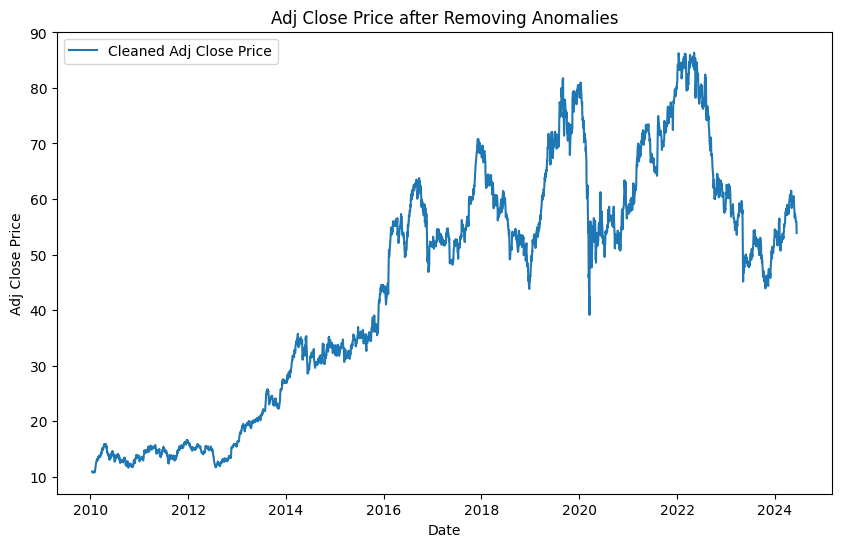

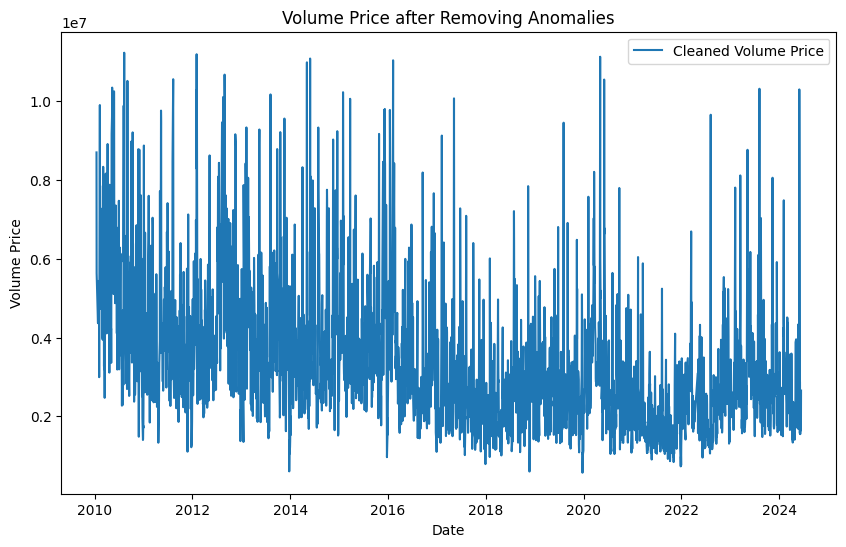

In [22]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 读取股票数据
data = pd.read_csv(filename)

# 将日期列转换为日期格式
data['Date'] = pd.to_datetime(data['Date'])

# 初始化孤立森林模型参数
contamination_rate = 0.01  # 异常值比例
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)

# 对每一列进行异常值检测
anomalies = pd.DataFrame(index=data.index)
for column in data.columns:
    if column != 'Date':
        values = data[column].values.reshape(-1, 1)
        anomalies[column] = iso_forest.fit_predict(values)

# 将异常值标记为1，正常值标记为0
anomalies = anomalies.applymap(lambda x: 1 if x == -1 else 0)

# 合并结果，只保留被识别为正常值的数据点
data['Anomaly'] = anomalies.sum(axis=1)
cleaned_data = data[data['Anomaly'] == 0]

# 打印去除异常值后的数据集信息
print(f'Number of anomalies detected and removed: {len(data) - len(cleaned_data)}')
print(f'Number of data points after removal: {len(cleaned_data)}')

# 可视化每个列的结果
for column in data.columns:
    if column != 'Date' and column != 'Anomaly':
        plt.figure(figsize=(10, 6))
        plt.plot(data['Date'], data[column], label=f'{column} Price')
        plt.scatter(data[data['Anomaly'] > 0]['Date'], data[data['Anomaly'] > 0][column], color='red', label='Anomaly')
        plt.xlabel('Date')
        plt.ylabel(f'{column} Price')
        plt.legend()
        plt.title(f'{column} Price with Anomalies')
        plt.show()

# 可视化去除异常值后的数据
for column in data.columns:
    if column != 'Date' and column != 'Anomaly':
        plt.figure(figsize=(10, 6))
        plt.plot(cleaned_data['Date'], cleaned_data[column], label=f'Cleaned {column} Price')
        plt.xlabel('Date')
        plt.ylabel(f'{column} Price')
        plt.legend()
        plt.title(f'{column} Price after Removing Anomalies')
        plt.show()

# 删除Anomaly列
cleaned_data = cleaned_data.drop(columns=['Anomaly'])

# 保存去除异常值后的数据集
cleaned_data.to_csv('./tmp/cleaned_stock_prices.csv', index=False)

In [23]:
### 3.VMD分解,取第一模态

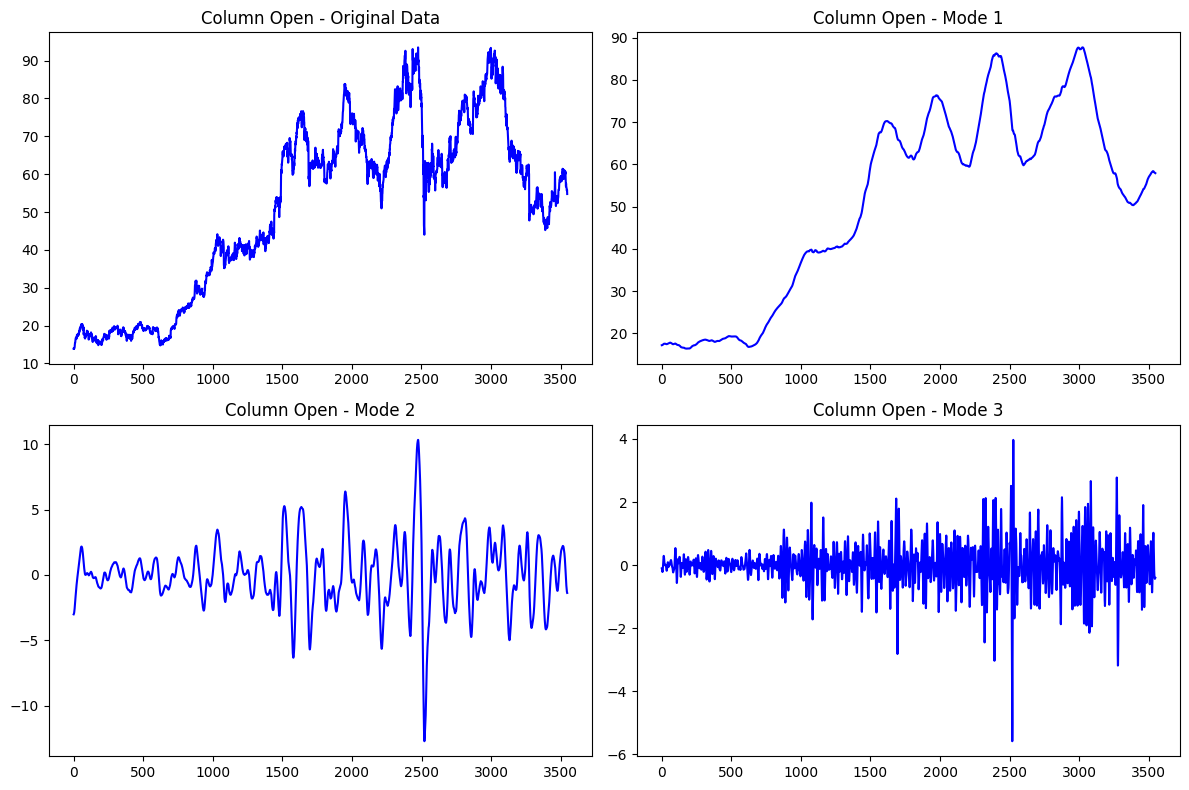

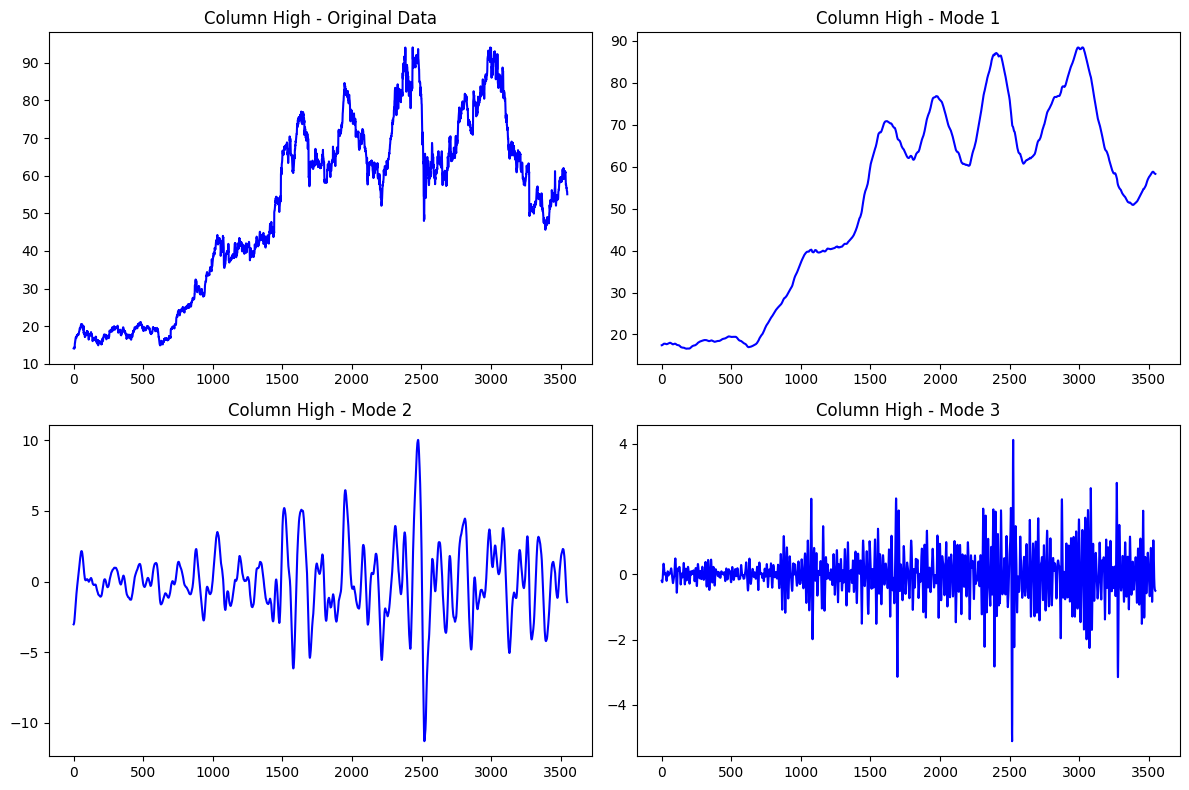

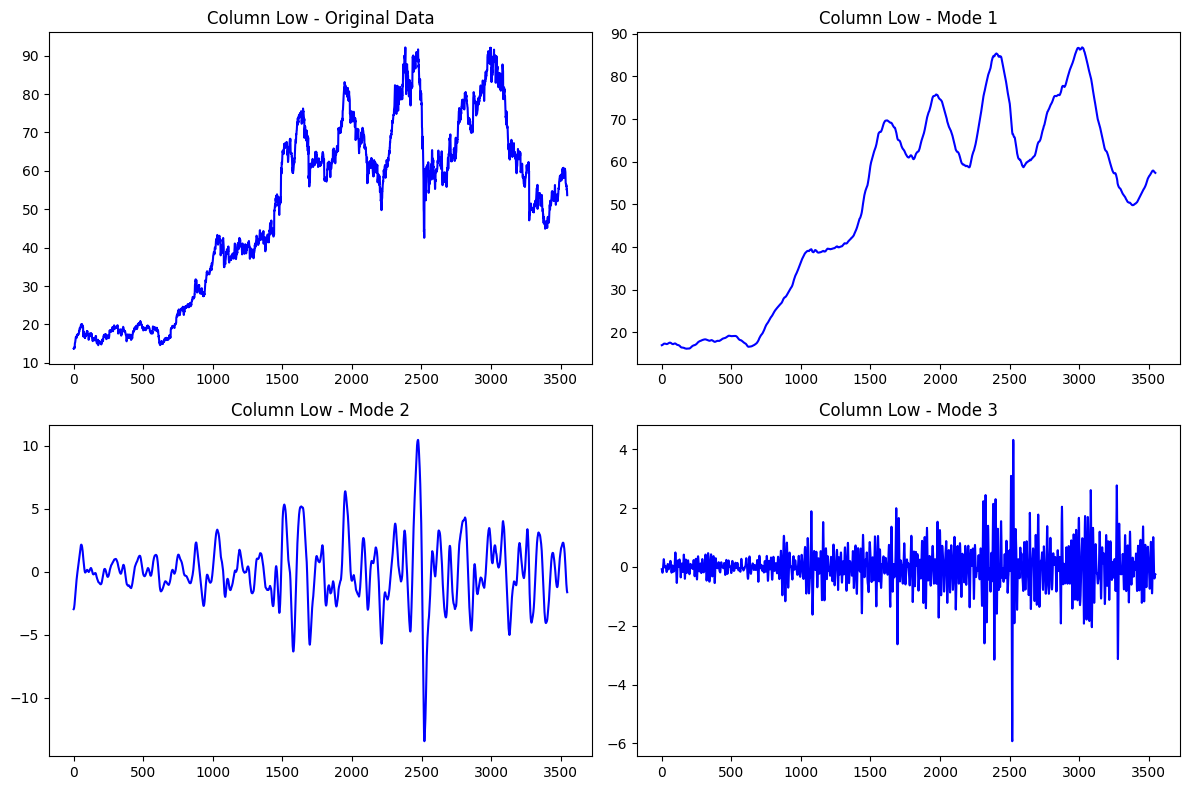

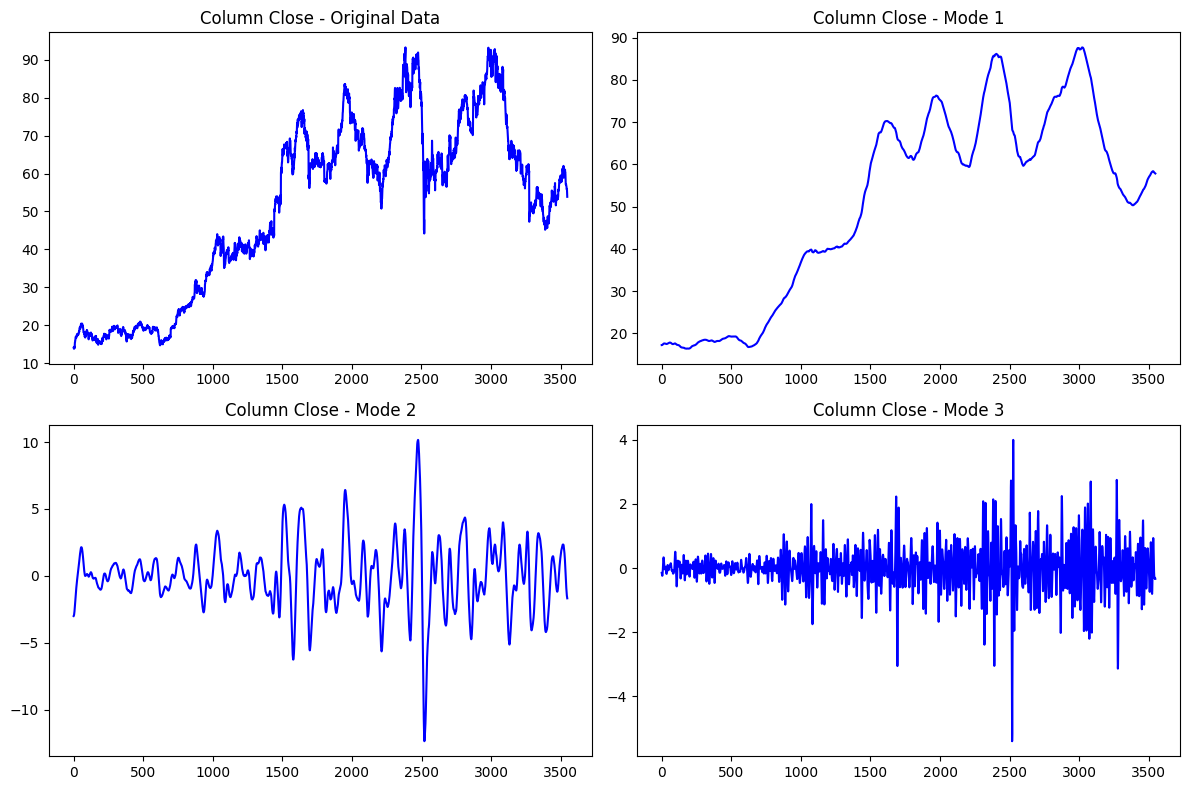

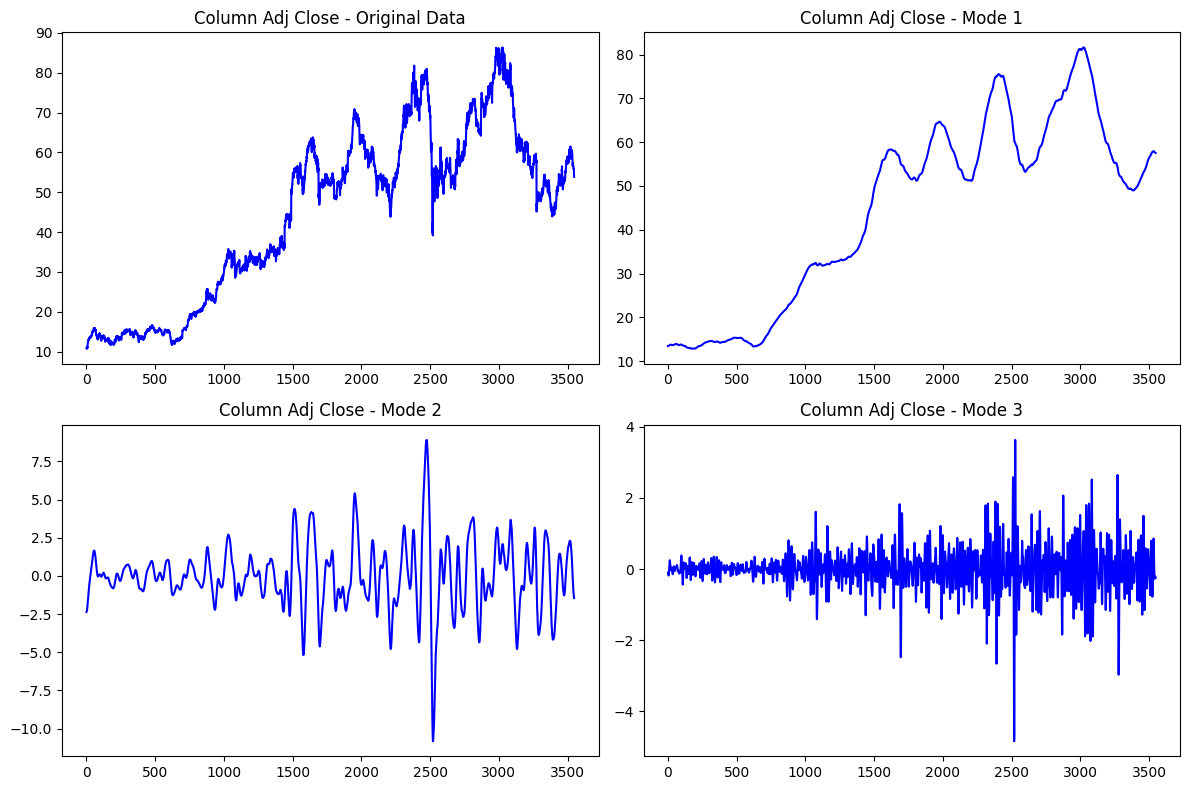

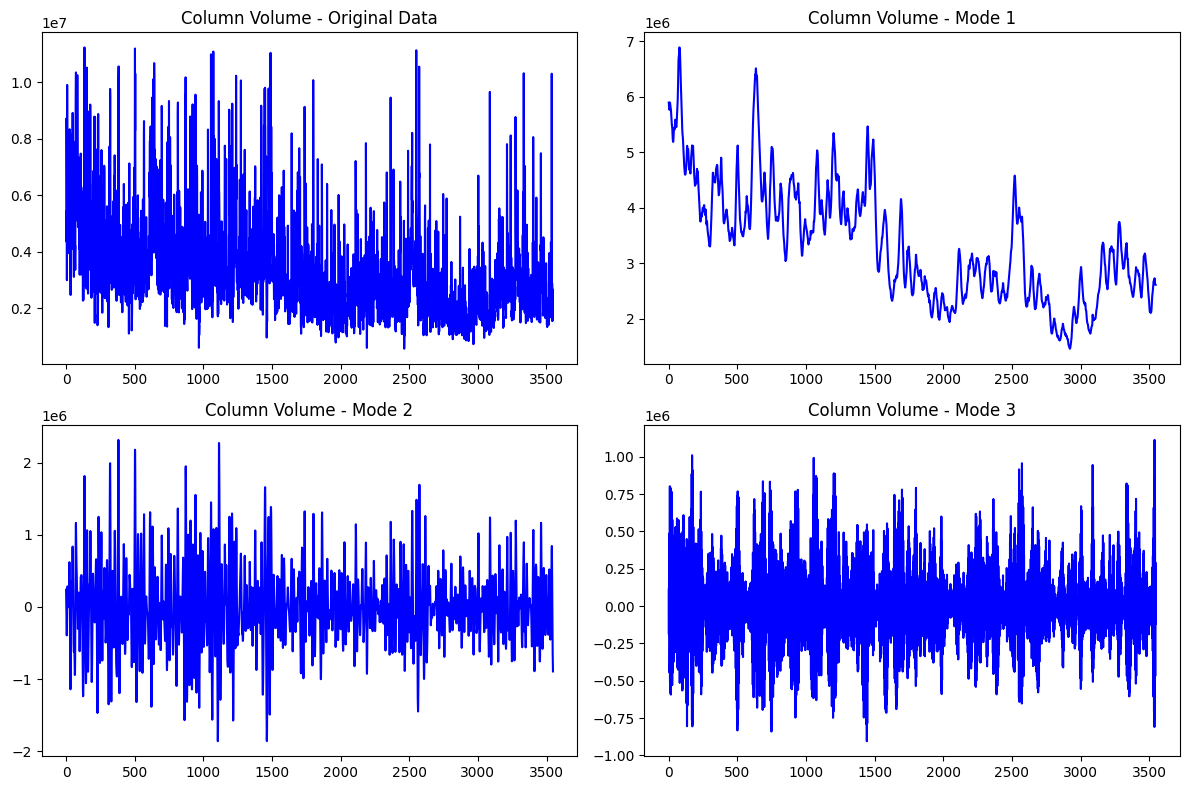

一阶模态数据已保存为 modes_1_combined.csv


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vmdpy import VMD

# 设置参数
alpha = 2000  # moderate bandwidth constraint
tau = 0.  # noise-tolerance (no strict fidelity enforcement)
K = 3  # number of modes
DC = 0  # no DC part imposed
init = 1  # initialize omegas uniformly
tol = 1e-7

# 假设 denoised_data 是一个二维数组，每列代表不同的数据序列
# 示例数据生成
# denoised_data = np.random.randn(4500, 4)  # 替换为实际数据
data = pd.read_csv('./tmp/cleaned_stock_prices.csv')
Date = pd.to_datetime(data['Date'])
denoised_data_pd = data.drop(columns=['Date'])
columns = denoised_data_pd.columns
denoised_data = denoised_data_pd.values
# 存储所有列的一阶模态
modes_1 = []

# 对每列数据进行VMD分解
for col in range(len(columns)):
    data = denoised_data[:, col].flatten()
    u, u_hat, omega = VMD(data, alpha, tau, K, DC, init, tol)

    # 提取一阶模态
    mode_1 = u[0]
    modes_1.append(mode_1)

    # 绘制原数据和模态
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(data, 'b')
    plt.title(f'Column {columns[col]} - Original Data')

    plt.subplot(2, 2, 2)
    plt.plot(u[0], 'b')
    plt.title(f'Column {columns[col]} - Mode 1')

    plt.subplot(2, 2, 3)
    plt.plot(u[1], 'b')
    plt.title(f'Column {columns[col]} - Mode 2')

    plt.subplot(2, 2, 4)
    plt.plot(u[2], 'b')
    plt.title(f'Column {columns[col]} - Mode 3')

    plt.tight_layout()
    plt.show()

# 将所有一阶模态拼接成新的数组
modes_1_combined = np.column_stack(modes_1)

# 保存为CSV文件
df_modes_1 = pd.DataFrame(modes_1_combined, columns=[f'M1_{i}' for i in columns])
df_modes_1 = pd.concat([Date, df_modes_1], axis=1)
df_modes_1.to_csv('./tmp/modes_1_combined.csv', index=False)

print("一阶模态数据已保存为 modes_1_combined.csv")


In [25]:
### 4.特征提取
# 4-1 自编码

In [26]:
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv('./tmp/cleaned_stock_prices.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# 数据标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 拆分数据集
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)

# 自编码器模型参数
input_dim = X_train.shape[1]
encoding_dim = 32

# 构建自编码器模型
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(64, activation='relu')(encoder)
encoder_output = Dense(encoding_dim, activation='relu')(encoder)

decoder = Dense(64, activation='relu')(encoder_output)
decoder = Dropout(0.2)(decoder)
decoder = Dense(128, activation='relu')(decoder)
decoder_output = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder_output)

# 编译模型
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 早停
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True,
                          validation_data=(X_test, X_test), callbacks=[early_stopping])

# 提取编码特征
encoder_model = Model(inputs=input_layer, outputs=encoder_output)
encoded_data = encoder_model.predict(data_scaled)

# 保存编码特征
encoded_df = pd.DataFrame(encoded_data, index=data.index)
encoded_df.to_csv('./tmp/encoded_features.csv')


Epoch 1/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1300 - val_loss: 1.0575
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.8474 - val_loss: 0.8355
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7239 - val_loss: 0.7446
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6323 - val_loss: 0.6827
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5926 - val_loss: 0.6580
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5791 - val_loss: 0.6547
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5749 - val_loss: 0.6541
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5719 - val_loss: 0.6499
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5698 - val_loss: 0.6481
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5673 - val_loss: 0.6465
Epoch 11

In [27]:
### 4-2 时序特征提取

In [28]:
import pandas as pd
import numpy as np
import ta

# 读取数据
data = pd.read_csv('./tmp/cleaned_stock_prices.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
columns = data.columns
# 构造常见的技术指标
data['SMA_10'] = data[target].rolling(window=10).mean()
data['SMA_50'] = data[target].rolling(window=50).mean()
data['RSI_14'] = ta.momentum.RSIIndicator(data[target], window=14).rsi()
macd = ta.trend.MACD(data[target])
data['MACD'] = macd.macd()
data['MACD_Signal'] = macd.macd_signal()
data['MACD_Hist'] = macd.macd_diff()
bb = ta.volatility.BollingerBands(data[target], window=20, window_dev=2)
data['BB_High'] = bb.bollinger_hband()
data['BB_Low'] = bb.bollinger_lband()
data['BB_Middle'] = bb.bollinger_mavg()
data['VWAP'] = (data['Volume'] * (data['High'] + data['Low'] + data[target]) / 3).cumsum() / data['Volume'].cumsum()
data['MFI'] = ta.volume.MFIIndicator(data['High'], data['Low'], data[target], data['Volume'],
                                     window=14).money_flow_index()
data['AD_Line'] = ta.volume.AccDistIndexIndicator(data['High'], data['Low'], data[target],
                                                  data['Volume']).acc_dist_index()
data['Lag_1'] = data[target].shift(1)
data['Lag_2'] = data[target].shift(2)
data['Lag_3'] = data[target].shift(3)
data['Rolling_Mean_7'] = data[target].rolling(window=7).mean()
data['Rolling_Std_7'] = data[target].rolling(window=7).std()
data['Rolling_Mean_30'] = data[target].rolling(window=30).mean()
data['Rolling_Std_30'] = data[target].rolling(window=30).std()
data['Rolling_Max_7'] = data[target].rolling(window=7).max()
data['Rolling_Min_7'] = data[target].rolling(window=7).min()
data['Rolling_Median_7'] = data[target].rolling(window=7).median()
data['Rolling_Quantile_7'] = data[target].rolling(window=7).quantile(0.75)
data['Pct_Change_7'] = data[target].pct_change(periods=7)
data['Pct_Change_30'] = data[target].pct_change(periods=30)
data['Volatility_7'] = data[target].rolling(window=7).std()
data['Momentum_14'] = data[target].diff(14)

# 生成每月特征
monthly_data = data.resample('ME').agg({
    'Open': 'first',
    target: 'last',
    'High': 'max',
    'Low': 'min',
    'Volume': 'sum'
}).rename(columns={
    'Open': 'Monthly_Open',
    target: 'Monthly_Close',
    'High': 'Monthly_High',
    'Low': 'Monthly_Low',
    'Volume': 'Monthly_Volume'
})
data = data.join(monthly_data, how='left').ffill()

data['SMA_10_50_Diff'] = data['SMA_10'] - data['SMA_50']

# 处理NaN值
data_filled = data.bfill().ffill()

# float_columns = data_filled.select_dtypes(include=[np.float64, np.float32])

# 查看处理后的数据
print(data_filled.tail())

# 保存处理后的数据
data_filled.to_csv('./tmp/processed_stock_data.csv')

                 Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2024-06-07  56.189999  56.619999  55.750000  55.860001  55.860001  1545000   
2024-06-10  55.669998  55.990002  55.000000  55.950001  55.950001  2412700   
2024-06-11  55.639999  55.880001  55.320000  55.720001  55.720001  1768300   
2024-06-12  55.860001  55.860001  54.470001  54.730000  54.730000  1640200   
2024-06-13  54.750000  55.060001  53.669998  53.860001  53.860001  2651500   

               SMA_10   SMA_50     RSI_14      MACD  ...  Pct_Change_7  \
Date                                                 ...                 
2024-06-07  57.157000  59.1814  29.393468 -0.913017  ...     -0.026320   
2024-06-10  56.781000  59.1242  30.413337 -0.965241  ...     -0.019625   
2024-06-11  56.575000  59.0640  29.250546 -1.013505  ...     -0.026725   
2024-06-12  56.311000  59.0016  24.846978 -1.118743  ...     -0.040161   
2024-06-1

In [29]:
# 5 特征选择 递归特征消除RFE
# 5-1 对时序特征processed_stock_data.csv

In [30]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv('./tmp/processed_stock_data.csv')
ini_data = pd.read_csv('./tmp/cleaned_stock_prices.csv')
columns = ini_data.columns
X = data.drop(columns=columns)
y = ini_data[target]

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用RFE进行特征选择
estimator = RandomForestRegressor()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

# 打印选出的特征
selected_features = X.columns[selector.support_]
print(f'Selected Features: {selected_features}')

# 使用选出的特征进行训练和评估
X_train_rfe = selector.transform(X_train)
X_test_rfe = selector.transform(X_test)
estimator.fit(X_train_rfe, y_train)
score_rfe = estimator.score(X_test_rfe, y_test)
print(f'RFE Score: {score_rfe}')

# 提取选中的特征数据
selected_data = data[selected_features]

# 保存到CSV文件
selected_data.to_csv('./tmp/final_selected_data_TIME.csv', index=False)

Selected Features: Index(['SMA_10', 'RSI_14', 'BB_High', 'Lag_1', 'Lag_2', 'Rolling_Mean_7',
       'Rolling_Max_7', 'Rolling_Min_7', 'Rolling_Median_7',
       'Rolling_Quantile_7'],
      dtype='object')
RFE Score: 0.9992196123774253


In [ ]:
# 5-2 对自编码器encode_features.csv

In [31]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv('./tmp/processed_stock_data.csv')
feature = pd.read_csv('./tmp/encoded_features.csv')
X = feature.drop(columns='Date')
y = data[target]

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用RFE进行特征选择
estimator = RandomForestRegressor()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

# 打印选出的特征
selected_features = X.columns[selector.support_]
print(f'Selected Features: {selected_features}')

# 使用选出的特征进行训练和评估
X_train_rfe = selector.transform(X_train)
X_test_rfe = selector.transform(X_test)
estimator.fit(X_train_rfe, y_train)
score_rfe = estimator.score(X_test_rfe, y_test)
print(f'RFE Score: {score_rfe}')

# 提取选中的特征数据
selected_data = feature[selected_features]

# 合并选中的特征数据和指定的列数

# 保存到CSV文件
selected_data.to_csv('./tmp/final_selected_data_VAE.csv', index=False)

Selected Features: Index(['0', '1', '2', '5', '10', '19', '22', '24', '29', '30'], dtype='object')
RFE Score: 0.9994824409281221


### 5-3对两种选出来的特征进行融合

In [32]:
TIME_data = pd.read_csv('./tmp/final_selected_data_TIME.csv')
VAE_data = pd.read_csv('./tmp/final_selected_data_VAE.csv')
mode_data = pd.read_csv('./tmp/modes_1_combined.csv')
raw_data = pd.read_csv('./tmp/cleaned_stock_prices.csv')
mode_data.drop(columns=['Date'], inplace=True)
final_data = pd.concat([raw_data, TIME_data, mode_data, VAE_data], axis=1)
final_data.to_csv('./tmp/final_data.csv', index=False)
print(final_data.head())

         Date   Open   High    Low  Close  Adj Close   Volume  SMA_10  \
0  2010-01-14  13.89  14.09  13.73  14.04  10.918697  8703500  14.253   
1  2010-01-15  14.08  14.08  13.76  13.89  10.802047  5633700  14.253   
2  2010-01-25  13.88  14.06  13.68  13.89  10.802047  4363300  14.253   
3  2010-01-27  13.98  14.02  13.72  13.78  10.716505  5437200  14.253   
4  2010-01-29  13.90  14.00  13.78  13.82  10.747610  4792900  14.253   

      RSI_14    BB_High  ...         0         1         2    5        10  \
0  86.737547  17.756509  ...  2.653790  6.232301  5.643313  0.0  5.775500   
1  86.737547  17.756509  ...  2.380909  5.990864  5.441236  0.0  5.401440   
2  86.737547  17.756509  ...  2.318709  6.013146  5.464139  0.0  5.529168   
3  86.737547  17.756509  ...  2.370277  5.996225  5.443871  0.0  5.414821   
4  86.737547  17.756509  ...  2.329106  5.999850  5.438829  0.0  5.466006   

         19        22   24   29        30  
0  2.912240  3.514063  0.0  0.0  4.190625  
1  1.96625